**Second order ODE**

Retyped by Theodoret Putra Agatho on 4 Aug. 2023

Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/ode.2nd.html

In [2]:
pip install deepxde

**Problem setup**

We will solve an ODE:

\begin{align}
        y''(t) - 10y'(t) + 9y(t) = 5t
    \end{align}

with initial conditions

\begin{align}
        y(0) = -1, y'(0) = 2
    \end{align}

For $t \in [0,0.25]$. The exaact solution is $y(t) = \frac{50}{81} + \frac{5}{9}t + \frac{31}{81}e^{9t} - 2e^t$.

**Implementation**

This description goes through the implementation of a solver for the above ODE step-by-step. First, the DeepXDE module is imported:

In [3]:
import deepxde as dde
import numpy as np

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


We begin by defining a computational geometry. We can use a built-in class `TimeDomain` as follows

In [4]:
geom = dde.geometry.TimeDomain(0, 0.25)

Next, we express the residual of the ODE

In [13]:
def ode(t, y):
  dy_dt = dde.grad.jacobian(y, t)
  d2y_dt2 = dde.grad.hessian(y, t)
  return d2y_dt2 - 10 * dy_dt + 9 * y - 5 * t

def func(t):
  return 50 / 81 + t * 5 / 9 - 2 * np.exp(t) + (31 / 81) * np.exp(9 * t)

The first argument to `ode` is the network input, i.e., the $t$-coordinate. The second argument is the network output, i.e., the solution $y(t)$, but here we use `y` as the name of the variable.

We define the initial condition, setting the value of the function at $t=0$ to $-1$.

In [6]:
ic1 = dde.icbc.IC(geom, lambda x: -1, lambda _, on_initial:on_initial)

Now we deal with the initial condition $y'(0) = 2$.

The location of the initial condition is defined by a simple Python function. The function should return `True` for those points satisfying $t = 0$ and `False` otherwise (note that because of rounding-off errors, it is often wise to use `dde.utils.isclose` to test whether two floating point values are equivalent). In this function, the argument `t` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d = 1$ in this case. Then a boolean `on_boundary` is used as the second argument. If the point `t` (the first argument) is on the boundary of the geometry, then `on_boundary` is `True`, otherwise, `on_boundary` is `False`.

In [7]:
def boundary_l(t, on_boundary):
  return on_boundary and dde.utils.isclose(t[0], 0)

Now we define a function that returns the error of the initial condition, $y'(0)=2$, which is the difference between the derivative of the output of the network at 0, and 2. The function takes arguments (`inputs`, `outputs`, `X`) and outputs a tensor of size `N x 1`, where `N` is the length of `inputs`. `inputs` and `outputs` are the network input and output tensors, respectively; `x` is the NumPy array of the `inputs`.

In [8]:
def error_2(inputs, outputs, X):
  return dde.grad.jacobian(outputs, inputs, i=0, j=None) - 2

Then, the initial condition is defined by

In [11]:
ic2 = dde.icbc.OperatorBC(geom, error_2, boundary_l)

Now, we have specified the geometry, PDE residual, and the initial conditions. We then define the PDE problem. Note: If you use _X_ in _func_, then do no set `num_test` when you define `dde.data.PDE` or `dde.data.TimePDE`, otherwise DeepXDE would throw an error. In this case, the training points will be used for testing, and this will not affect the network training and training loss. This is a bug of DeepXDE, which cannot be fixed in an easy way for all backends.

In [14]:
data = dde.data.TimePDE(geom, ode, [ic1, ic2], 16, 2, solution=func, num_test=500)

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the humber of training points sampled on the boundary. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 500 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [15]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model`, choose the optimizer, set the learning rate to 0.001, and train the network for 15000 iterations. We set the weight of the ODE loss to 0.01, and the weights of the two ICs to 1. We also compute the $L^2$ relative error as a metric during training.

In [16]:
model = dde.Model(data, net)
model.compile("adam", lr=.001, loss_weights=[0.01, 1, 1], metrics=['l2 relative error'])
losshistory, train_state = model.train(iterations=15000)

Compiling model...
Building feed-forward neural network...
'build' took 0.102666 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.698764 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.38e-03, 1.00e+00, 4.35e+00]    [1.91e-03, 1.00e+00, 4.35e+00]    [1.00e+00]    
1000      [1.08e+00, 8.73e-01, 8.69e-01]    [1.05e+00, 8.73e-01, 8.69e-01]    [9.35e-01]    
2000      [3.58e-03, 8.82e-05, 2.68e-03]    [4.07e-03, 8.82e-05, 2.68e-03]    [7.73e-03]    
3000      [2.00e-04, 8.74e-08, 2.27e-07]    [2.43e-04, 8.74e-08, 2.27e-07]    [1.04e-03]    
4000      [1.59e-04, 1.19e-08, 1.87e-08]    [1.92e-04, 1.19e-08, 1.87e-08]    [9.77e-04]    
5000      [1.23e-04, 3.03e-08, 6.57e-08]    [1.51e-04, 3.03e-08, 6.57e-08]    [8.77e-04]    
6000      [1.80e-04, 1.52e-06, 6.03e-05]    [2.43e-04, 1.52e-06, 6.03e-05]    [7.55e-04]    
7000      [6.68e-05, 1.14e-08, 3.37e-08]    [8.49e-05, 1.14e-08, 3.37e-08]    [6.18e-04]    
8000      [3.38e-03, 8.66e-05, 2.40e-03]    [3.63e-03, 8.66e-05, 2.40e-03]    [8.37e-03]    
9000      [2.83e-05, 1.7

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


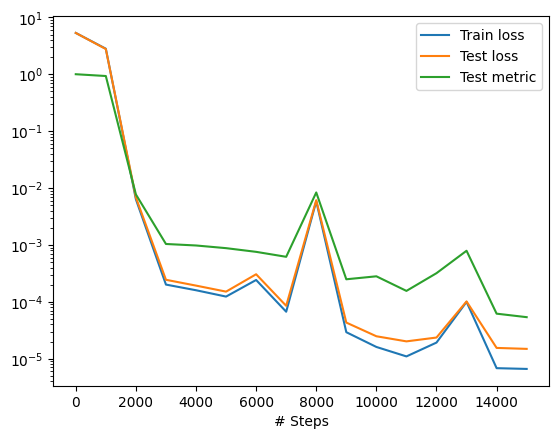

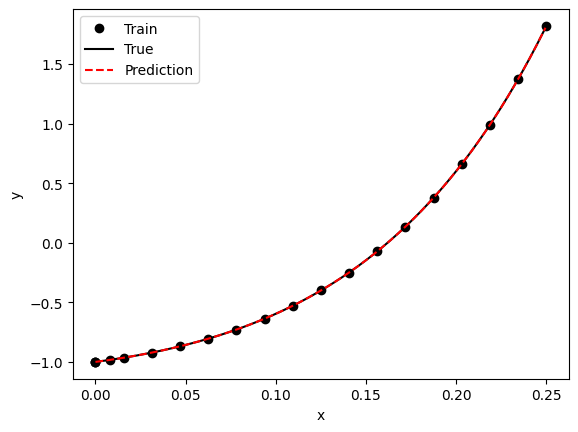

In [17]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)